# Cloud Locking Analysis
This notebook does the following calculations: 
1. Calculates rolling 30-year SST trends in EPT for Locked and Interactive
2. Calculates regression maps between 30-year EPT SST trends and 30-year point-wise Surface Latent Heating and Surface Shortwave Radiation Trends

In [1]:
import os
import numpy as np
import xarray as xr
import xcdat as xc
import xskillscore as xscore

ROOT = "/p/user_pub/climate_work/zelinka1/cloud_locking/CloudTVar_Manuscript_Data"

# Define Helper Functions

### Get Regrided Data on 1 deg x 1 deg

In [10]:
def regrid(ds, var, calc_anoms=True): 
    """Regrid Data to 1 deg x 1 deg using xesmf and bilinear interpolation

    Args:
        ds (xr.Dataset)
        var (str): variable in ds
        calc_anoms (bool, optional): Calculate anomalies using xcdat. Defaults to True.

    Returns:
        ds_regrid: ds with regridded data
        ds_regrid_anoms: ds anomalies with regridded data
    """
    # Create output grid
    lat = np.arange(-88.75, 90, 2.5)
    lon = np.arange(1.25, 360, 2.5)
    output_grid = xc.create_grid(lat, lon)

    # Regrid Data
    ds_regrid = ds.regridder.horizontal(var, output_grid, tool='xesmf', method='bilinear')

    # Deseasonalize (no need to detrend piControl data, there should be no drift)
    if calc_anoms:
        ds_regrid_anoms = ds_regrid.temporal.departures(var, "month")

    return ds_regrid, ds_regrid_anoms


### Get EPT data

In [11]:
def fix_coords(data):
    data = data.bounds.add_bounds("X")
    data = data.bounds.add_bounds("Y")
    data = xc.swap_lon_axis(data, to=(-180, 180))
    return data

def get_triangle(da, latmin: float = -38.75, latmax: float = -1.25, lonmin: float = -178.75, lonmax: float = -71.25, RES: float = 2.5):
    """Get EPT Sector

    Args:
        da (_type_): _description_
        latmin (float, optional): _description_. Defaults to -38.75.
        latmax (float, optional): _description_. Defaults to -1.25.
        lonmin (float, optional): _description_. Defaults to -178.75.
        lonmax (float, optional): _description_. Defaults to -71.25.
        RES (float, optional): _description_. Defaults to 2.5.

    Returns:
        _type_: _description_
    """
    DY = latmax - latmin
    DX = lonmax - lonmin 
    dx = RES*round(DX/DY)
    dy = RES

    print(f"For each latitude step of {dy} degrees, longitude step is {dx}")

    latcoords = np.arange(latmax, latmin-dy, -dy)
    loncoords = np.arange(lonmin, lonmax+dx, dx)
    lonraw = np.arange(lonmin, lonmax+dx, RES)

    da_cur = da.sel(lon=slice(lonmin, lonmax), lat=slice(latmin, latmax))
    ntime, _, nlon = da_cur.shape
    # print(ctos)

    for i, clon in enumerate(lonraw):
        j = np.where(clon == loncoords)[0]

        if i == nlon: break

        if len(j) == 0: 
            j = jold
        else: 
            j = j[0]
             
        nlats = int(len(latcoords) - j) # nlats below diag
        da_cur[:,:nlats,i] = np.full((ntime, nlats), np.nan) 
        
        jold = j
    
    return da_cur


### Get Rolling Trends

In [12]:
def calculate_rolling_gradient(data: xr.DataArray, window: int = 12*30, step: int = 12) -> xr.DataArray:
    """Calculate the rolling gradient of a dataset

    Args:
        data (xr.DataArray): _description_
        window (int, optional): _description_. Defaults to 120*30.
        step (int, optional): _description_. Defaults to 12.

    Returns:
        np.array: _description_
    """
    
    # Time must be first dimension
    assert data.dims[0] == 'time'

    # check if more than 1-dimension
    if len(data.dims) > 1:
        # Create numpy array with nans that is equal to the number of 30-year trends 
        shape = (int((data.shape[0] - window) / step), data.shape[1], data.shape[2])
    else:
        shape = (int((data.shape[0] - window) / step))

    # Create np array with nans that is equal to the number of 30-year trends
    grads = np.full(shape, np.nan)
    
    time_idx = xr.DataArray(np.arange(window), dims="time")
    # data = data.chunk({"time": -1})

    for j, i in enumerate(range(0, len(data.time) - window, step)):
        if len(data.dims) > 1:
            grads[j,:,:] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=False).values
        else:
            grads[j] = xscore.linslope(time_idx, data.isel(time=slice(i, i+window)), dim='time', skipna=False).values

    # Convert to xarray
    if len(data.dims) > 1:
        # Multiply by window so trend is SST/30 years rather than SST/month
        da =  xr.DataArray(grads*window, dims=("time", "lat", "lon"), coords={"time": np.arange(grads.shape[0]), "lat": data.lat, "lon": data.lon})
    else: 
        da =  xr.DataArray(grads*window, dims=("time"), coords={"time": np.arange(grads.shape[0])})
    
    return da


### Get Regression Coeffs between Map of 30-year Trends for each Var and  30-year EPT Trends

In [13]:
def regression_coeffs(ds_map, ds):
    """
    Calculate the regression coefficient between a time series of 30-year trends and a 
    map of 30-year trends. Then multiply by 1-sigma to get the 1-sigma regression coefficient.
    """
    # First standardize the data
    ds = (ds - ds.mean("time")) / ds.std('time')
    
    # METHOD 1: Composite Analysis - Get times from map where ds is less than 1 sigma
    # map = xr.where(ds <= -1., ds_map, np.nan)
    # map = map.mean("time")
    
    # Method 2: Regression Coefficient
    map = xscore.linslope(ds, ds_map, dim='time', skipna=False)
    
    return map


# Run pipeline

In [6]:
interactive_data = [
    "InteractiveClouds_SurfaceShortwaveRadiation_Ocean.nc",
    "InteractiveClouds_SurfaceLatentHeat_Ocean.nc",        
    "InteractiveClouds_SurfaceTemperature_Ocean.nc",       
    "InteractiveClouds_SurfaceLongwaveRadiation_Ocean.nc",
    "InteractiveClouds_SurfaceSensibleHeat_Ocean.nc"       
]

locked_data = [
    "LockedClouds_SurfaceLongwaveRadiation_Ocean.nc",
    "LockedClouds_SurfaceSensibleHeat_Ocean.nc",
    "LockedClouds_SurfaceShortwaveRadiation_Ocean.nc",
    "LockedClouds_SurfaceLatentHeat_Ocean.nc",             
    "LockedClouds_SurfaceTemperature_Ocean.nc"
]

def load_data(files):
    ds = xr.open_mfdataset([os.path.join(ROOT, f) for f in files]) #, chunks={"time": -1})
    ds = ds.load()
    return ds

ds_int = load_data(interactive_data)
ds_locked = load_data(locked_data)
ds_locked


<xarray.Dataset>
Dimensions:  (lon: 192, lat: 96, time: 2400)
Coordinates:
  * lon      (lon) float64 0.0 1.875 3.75 5.625 7.5 ... 352.5 354.4 356.2 358.1
  * lat      (lat) float64 88.57 86.72 84.86 83.0 ... -83.0 -84.86 -86.72 -88.57
  * time     (time) datetime64[ns] 1901-01-31T23:52:00 ... 2100-12-31T23:52:0...
Data variables:
    ahfl     (time, lat, lon) float32 1.194 1.061 1.026 0.924 ... nan nan nan
    ahfs     (time, lat, lon) float32 18.46 18.19 18.15 17.9 ... nan nan nan nan
    srads    (time, lat, lon) float32 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan
    trads    (time, lat, lon) float32 -37.19 -36.77 -36.62 ... nan nan nan
    tsurf    (time, lat, lon) float32 252.7 252.8 252.9 252.9 ... nan nan nan

In [7]:
# Calculate EPT SST Trends
def get_ept_trends(ds_int, cvar):
    print("Regridding")
    _, ds_cvar = regrid(ds_int, var=cvar)

    print("Getting EPT")
    ds_cvar = xc.swap_lon_axis(ds_cvar, to=(-180, 180))
    ds_ept = get_triangle(ds_cvar[cvar])
    ds_ept = fix_coords(ds_ept.rename(cvar).to_dataset()).spatial.average(cvar)[cvar]

    print("Calculating trends")
    ds_ept_trends = calculate_rolling_gradient(ds_ept)

    return ds_ept_trends

cvar = "tsurf"
ds_ept_trends_int = get_ept_trends(ds_int, cvar)
ds_ept_trends_locked = get_ept_trends(ds_locked, cvar)

Regridding
Getting EPT
For each latitude step of 2.5 degrees, longitude step is 7.5
Calculating trends
Regridding
Getting EPT
For each latitude step of 2.5 degrees, longitude step is 7.5
Calculating trends


In [8]:
# Ignore xarray warnings (bad practice)
import warnings
warnings.simplefilter("ignore") 


def run_pipeline(ds, ds_ept_sst, save_name):
    """Run the pipeline (1. regrid, 2. get EPT, 3. calculate trends, 4. calculate regression coefficients)

    Args:
        ds (xr.Dataset): ds with data
        ds_ept_sst (xr.DataArray): ds with EPT SST
    """
    regs, map_trends, ept_trends = [], [], []

    for i, cvar in enumerate(ds.data_vars):
        # if i == 2: break # TESTING

        print("Starting: ", cvar)
        _, ds_cvar = regrid(ds, var=cvar)

        print("Getting EPT")
        ds_ept = xc.swap_lon_axis(ds_cvar, to=(-180, 180))
        ds_ept = get_triangle(ds_ept[cvar])
        ds_ept = fix_coords(ds_ept.rename(cvar).to_dataset()).spatial.average(cvar)

        print("Calculating trends")
        # Calculate
        ds_ept_trends = calculate_rolling_gradient(ds_ept[cvar])
        ds_map_trends = calculate_rolling_gradient(ds_cvar[cvar])

        ds_ept_trends = ds_ept_trends.rename(f"{cvar}_ept_trends")
        ds_map_trends = ds_map_trends.rename(f"{cvar}_map_trends")

        # Save 
        ds_map_trends.to_netcdf(os.path.join("data", "MPI_Cloud_Locking", f"{cvar}_map_trends_{save_name}.nc"))
        ds_ept_trends.to_netcdf(os.path.join("data", "MPI_Cloud_Locking", f"{cvar}_ept_trends_{save_name}.nc"))

        print("Get 1-Sigma Regression Coefficients")
        # Calculate
        reg_map = regression_coeffs(
            ds_map=ds_map_trends, 
            ds=ds_ept_sst,
        ) 
        reg_map = reg_map.rename(f"{cvar}_reg_coef")

        # Save
        reg_map.to_netcdf(os.path.join("data", "MPI_Cloud_Locking", f"{cvar}_reg_coef_{save_name}.nc"))

        regs.append(reg_map)
        map_trends.append(ds_map_trends)
        ept_trends.append(ds_ept_trends)

    regs = xr.merge(regs)
    map_trends = xr.merge(map_trends)
    ept_trends = xr.merge(ept_trends)

    return regs, map_trends, ept_trends

regs_int, map_trends_int, ept_trends_int = run_pipeline(ds_int, ds_ept_trends_int, save_name="interactive")
regs_lock, map_trends_lock, ept_trends_lock = run_pipeline(ds_locked, ds_ept_trends_locked, save_name="locked")

Starting:  ahfl
Getting EPT
For each latitude step of 2.5 degrees, longitude step is 7.5
Calculating trends
Get 1-Sigma Regression Coefficients
Starting:  ahfs
Getting EPT
For each latitude step of 2.5 degrees, longitude step is 7.5
Calculating trends
Get 1-Sigma Regression Coefficients
Starting:  srads
Getting EPT
For each latitude step of 2.5 degrees, longitude step is 7.5
Calculating trends
Get 1-Sigma Regression Coefficients
Starting:  trads
Getting EPT
For each latitude step of 2.5 degrees, longitude step is 7.5
Calculating trends
Get 1-Sigma Regression Coefficients
Starting:  tsurf
Getting EPT
For each latitude step of 2.5 degrees, longitude step is 7.5
Calculating trends
Get 1-Sigma Regression Coefficients
Starting:  ahfl
Getting EPT
For each latitude step of 2.5 degrees, longitude step is 7.5
Calculating trends
Get 1-Sigma Regression Coefficients
Starting:  ahfs
Getting EPT
For each latitude step of 2.5 degrees, longitude step is 7.5
Calculating trends
Get 1-Sigma Regression Co

# Plotting

## Timeseries Comparison

In [2]:
import matplotlib.pyplot as plt
import scipy.stats as stats


def f_test(int_trends, lock_trends):
    # PERFORM F-TEST (ONE SIDED THAT VAR_LOCKED < VAR_INT)
    time = int_trends.time

    var_int = np.around(int_trends.var().values, 2)
    var_locked = np.around(lock_trends.var().values, 2)

    df1 = 120 #len(time) - 1
    df2 = 120 #len(time) - 1
    f = var_locked/var_int
    p = stats.f.cdf(f, df1, df2)

    print(f"F-test p-value: {p} and f-value: {f}")

    return p, var_int, var_locked


def plot_timeseries(int_trends, lock_trends, label_info):
    p, var_int, var_locked = f_test(int_trends, lock_trends)
    std_int = np.around(np.sqrt(var_int), 2)   
    std_locked = np.around(np.sqrt(var_locked), 2)

    # Plot timeseries
    plt.plot(int_trends.time, int_trends, label=f"Interactive ({std_int})")
    plt.plot(lock_trends.time, lock_trends, label=f"Locked ({std_locked})")

    # Format Figure
    fig = plt.gcf()
    fig.set_size_inches(10, 5)

    plt.grid()
    plt.legend()

    plt.title(label_info["left_title"], loc="left", fontweight="bold")
    plt.title(f"F-test p={np.around(p, 3)}", loc="right", fontweight="bold")
    plt.xlabel("Time (years)", fontweight="bold")
    plt.ylabel(label_info["ylabel"], fontweight="bold")

    plt.savefig(os.path.join("data", "MPI_Cloud_Locking", "Figures", f"{label_info['save_name']}_timeseries.png"), dpi=300, bbox_inches="tight")

F-test p-value: 0.49999999999999983 and f-value: 1.0


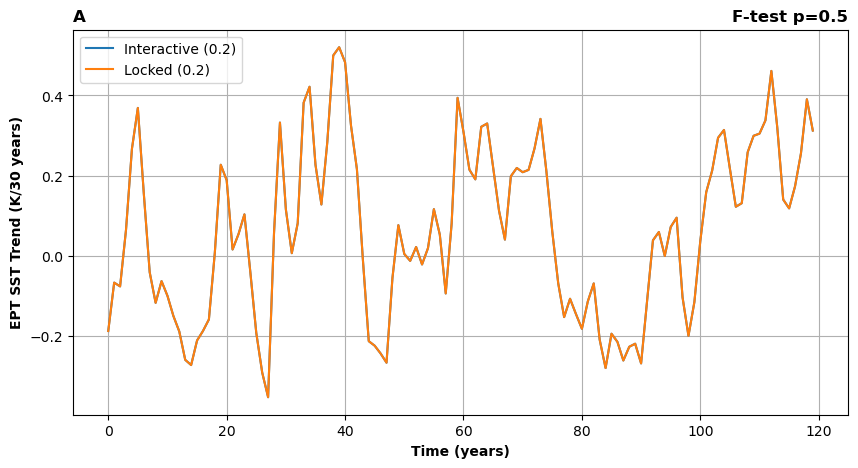

In [4]:
cesm1_cam5 = xr.open_dataarray(os.path.join("data", "piControl", "rolling_gradient_cmip5_eastPacificTriangle_trend.nc")).sel(model="CESM1-CAM5")
cesm1_cam5
print(cesm1_cam5)

label_info = {
 "left_title": "A", 
 "save_name": "cesm1-cam5_ept_trends",
 "ylabel": "EPT SST Trend (K/30 years)" 
}

plot_timeseries(
    int_trends=cesm1_cam5,
    lock_trends=cesm1_cam5,
    label_info=label_info
)

F-test p-value: 0.0007111135081796738 and f-value: 0.5555555555555556


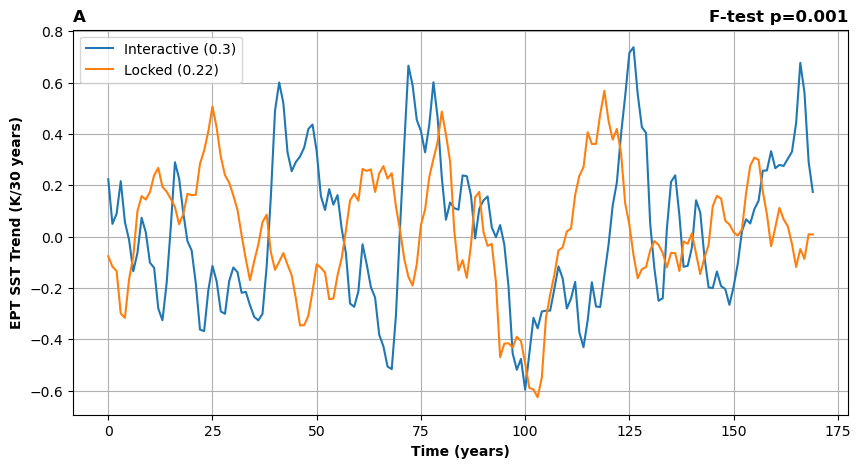

In [12]:
label_info = {
 "left_title": "A", 
 "save_name": "tsurf_ept_trends",
 "ylabel": "EPT SST Trend (K/30 years)" 
}

plot_timeseries(
    int_trends=ept_trends_int["tsurf_ept_trends"],
    lock_trends=ept_trends_lock["tsurf_ept_trends"],
    label_info=label_info
)

F-test p-value: 0.11886248344664316 and f-value: 0.8055555555555555


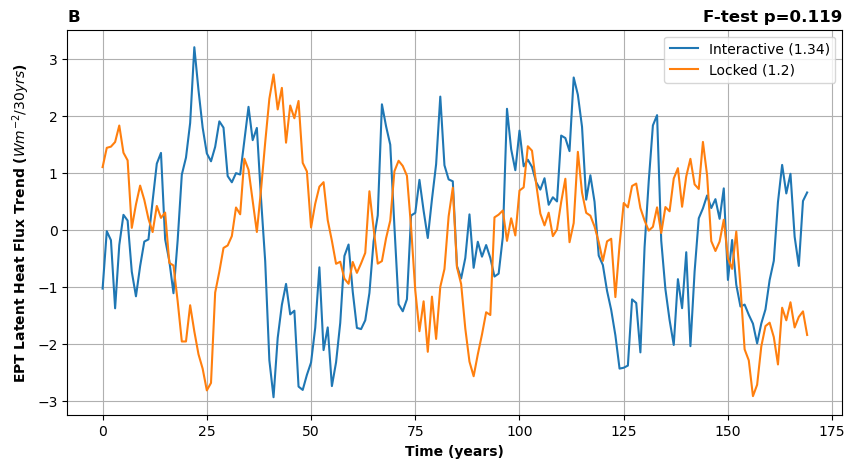

In [13]:
label_info = {
 "left_title": "B", 
 "save_name": "ahfl_ept_trends",
 "ylabel": r"EPT Latent Heat Flux Trend ($Wm^{-2}/30yrs$)" 
}

plot_timeseries(
    int_trends=ept_trends_int["ahfl_ept_trends"],
    lock_trends=ept_trends_lock["ahfl_ept_trends"],
    label_info=label_info
)

F-test p-value: 0.9988039290114807 and f-value: 1.5999999999999999


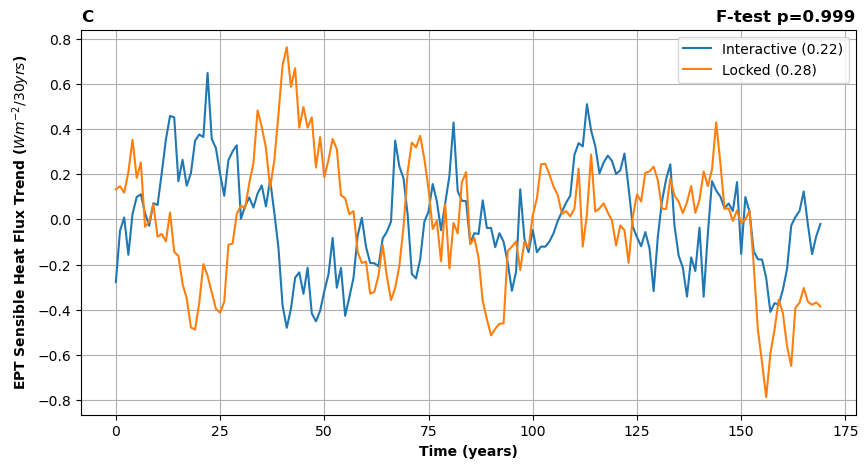

In [176]:
label_info = {
 "left_title": "C", 
 "save_name": "ahfs_ept_trends",
 "ylabel": r"EPT Sensible Heat Flux Trend ($Wm^{-2}/30yrs$)" 
}

plot_timeseries(
    int_trends=ept_trends_int["ahfs_ept_trends"],
    lock_trends=ept_trends_lock["ahfs_ept_trends"],
    label_info=label_info
)


F-test p-value: 1.2800195372604222e-29 and f-value: 0.15853658536585366


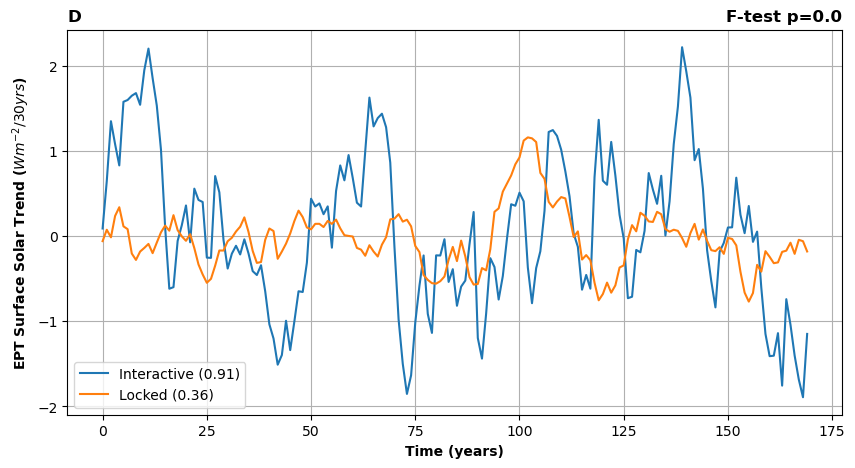

In [177]:
label_info = {
 "left_title": "D", 
 "save_name": "srads_ept_trends",
 "ylabel": r"EPT Surface Solar Trend ($Wm^{-2}/30yrs$)" 
}

plot_timeseries(
    int_trends=ept_trends_int["srads_ept_trends"],
    lock_trends=ept_trends_lock["srads_ept_trends"],
    label_info=label_info
)

F-test p-value: 0.00025306099075721996 and f-value: 0.5833333333333334


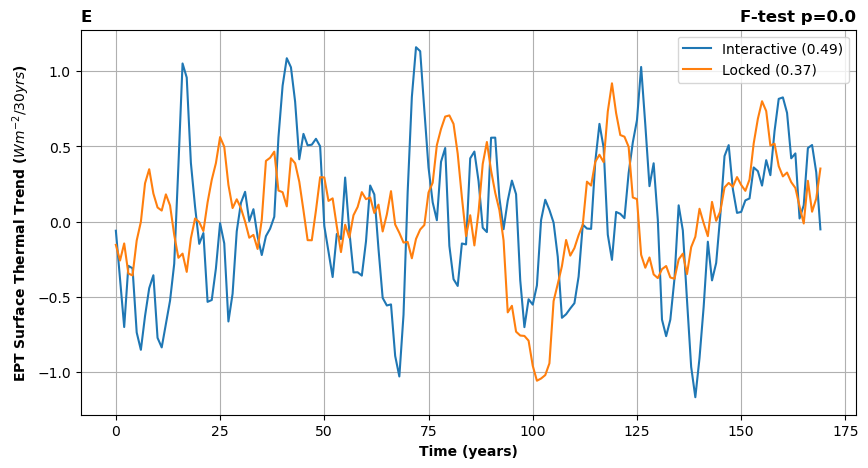

In [178]:
label_info = {
 "left_title": "E", 
 "save_name": "trads_ept_trends",
 "ylabel": r"EPT Surface Thermal Trend ($Wm^{-2}/30yrs$)" 
}

plot_timeseries(
    int_trends=ept_trends_int["trads_ept_trends"],
    lock_trends=ept_trends_lock["trads_ept_trends"],
    label_info=label_info
)

## Map Comparison

In [15]:
import cartopy.crs as ccrs
import cartopy
import matplotlib.pyplot as plt
import cmcrameri.cm as cmc
from matplotlib.gridspec import GridSpec

In [17]:
def _global_plot(ax, data, lon, lat, cmap, right_title="", left_title="", levels=np.arange(-4, 4.1, .1), cbar_label: str = ""):
    # plot map of global data with central longitude 180
    img = ax.contourf(
        lon, lat, data,
        transform=ccrs.PlateCarree(), cmap=cmap,
        extend="both",
        levels=levels,
    )
    ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')

    ax.add_feature(cartopy.feature.LAND, facecolor="gray", edgecolor="black", zorder=3)

    # Draw triangular region
    lat_min, lat_max = -40, 0
    lon_min, lon_max = -180, -70
    ax.plot(
        [lon_min, lon_max, lon_max, lon_min], 
        [lat_max, lat_max, lat_min, lat_max], 
        color="black", linewidth=2, transform=ccrs.PlateCarree(), zorder=10
    )

    ax.coastlines()
    ax.set_global()
    ax.set_title(left_title, loc="left", fontweight="bold")
    ax.set_title(right_title, loc="right")
    lon_min, lon_max = -180, 180
    lat_min, lat_max = -65, 65
    ax.set_extent([lon_min, lon_max, lat_min, lat_max], crs=ccrs.PlateCarree())

    return img

def regression_maps(ds_int, ds_lock, ds_dif, info):
    fig = plt.figure(figsize=(12,12))
    gs = GridSpec(3, 1)
    ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
    ax2 = fig.add_subplot(gs[1], projection=ccrs.PlateCarree(central_longitude=180))
    ax3 = fig.add_subplot(gs[2], projection=ccrs.PlateCarree(central_longitude=180))
    fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, hspace=.25, wspace=0.15)

    levels = info["levels"]
    cmap = "RdBu_r"

    _ = _global_plot(
        ax1,
        data=ds_int,
        lat=ds_int.lat,
        lon=ds_int.lon,
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )
    _ = _global_plot(
        ax2,
        data=ds_lock,
        lat=ds_lock.lat,
        lon=ds_lock.lon,
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )
    img = _global_plot(
        ax3,
        data=ds_dif,
        lat=ds_dif.lat,
        lon=ds_dif.lon,
        levels=levels,
        cmap=cmap, 
        cbar_label="K/30yr"
    )

    title_fontsize = 12
    ax1.set_title(info["right_title_1"], loc="right", fontweight="bold", fontsize=title_fontsize)
    ax2.set_title(info["right_title_2"], loc="right", fontweight="bold", fontsize=title_fontsize)
    ax3.set_title(info["right_title_3"], loc="right", fontweight="bold", fontsize=title_fontsize)

    ax1.set_title(info["left_title_1"], loc="left", fontweight="bold", fontsize=title_fontsize)
    ax2.set_title(info["left_title_2"], loc="left", fontweight="bold", fontsize=title_fontsize)
    ax3.set_title(info["left_title_3"], loc="left", fontweight="bold", fontsize=title_fontsize)

    cbar = fig.colorbar(img, ax=[ax1, ax2, ax3], orientation='vertical', location="right", fraction=.1, pad=0.01)
    cbar.ax.set_title(info["cbar_label"], fontsize=12, fontweight="bold")

    save_name = info["save_name"]
    plt.savefig(os.path.join("data", "MPI_Cloud_Locking", "Figures", f"{save_name}_reg_coeffs.png"), dpi=400, bbox_inches='tight')


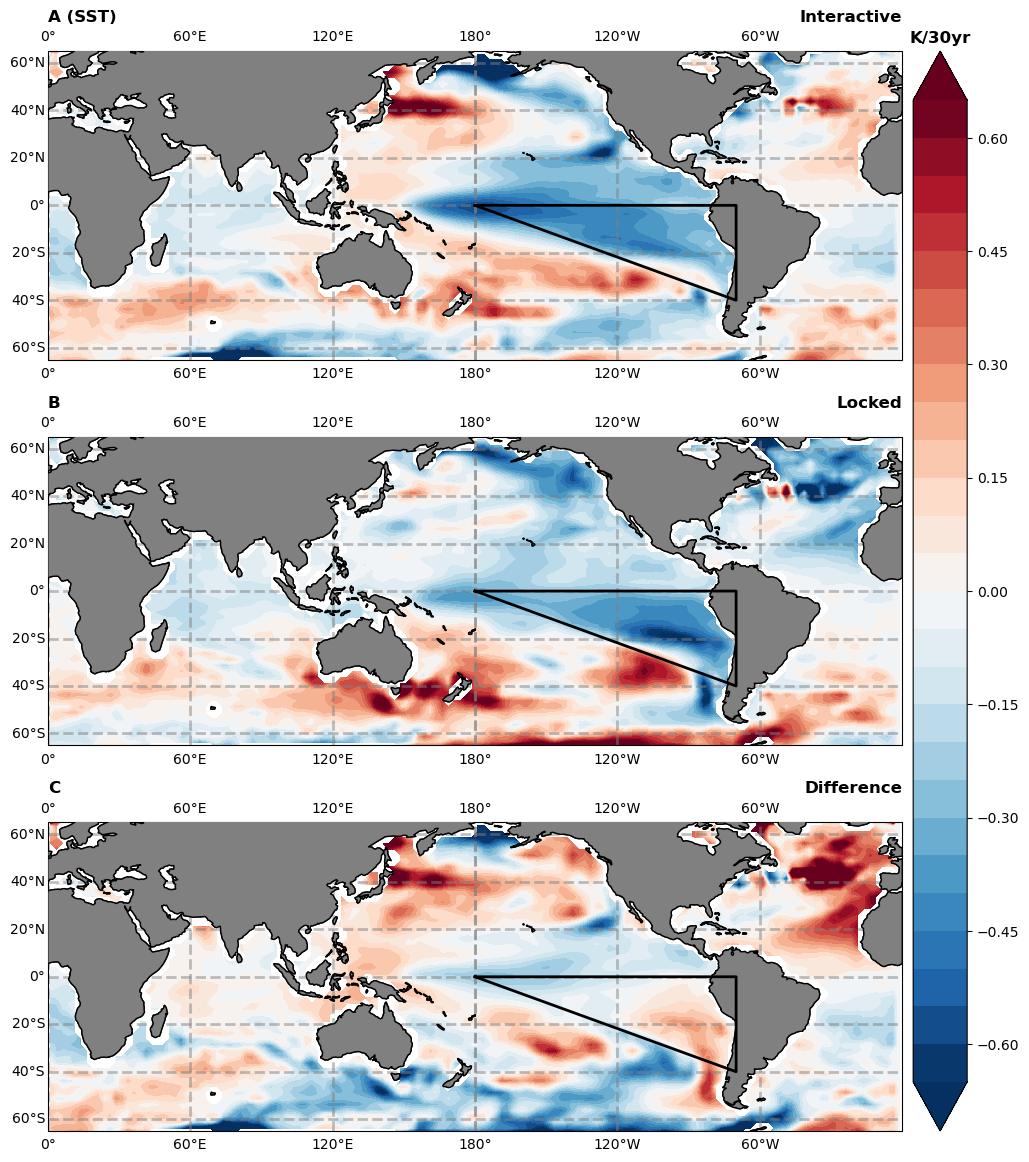

In [214]:
info = {
    "save_name": "tsurf_comp", 
    "right_title_1": "Interactive",
    "right_title_2": "Locked",
    "right_title_3": "Difference",
    "left_title_1": "A (SST)",
    "left_title_2": "B",
    "left_title_3": "C",
    "cbar_label": r"K/30yr",
    "levels": np.arange(-.65, .70, .05)
    # "levels": np.arange(-1.0, 1.05, .05)
}

regression_maps(
    ds_int=regs_int["tsurf_reg_coef"],
    ds_lock=regs_lock["tsurf_reg_coef"],
    ds_dif=regs_int["tsurf_reg_coef"] - regs_lock["tsurf_reg_coef"],
    info=info
)

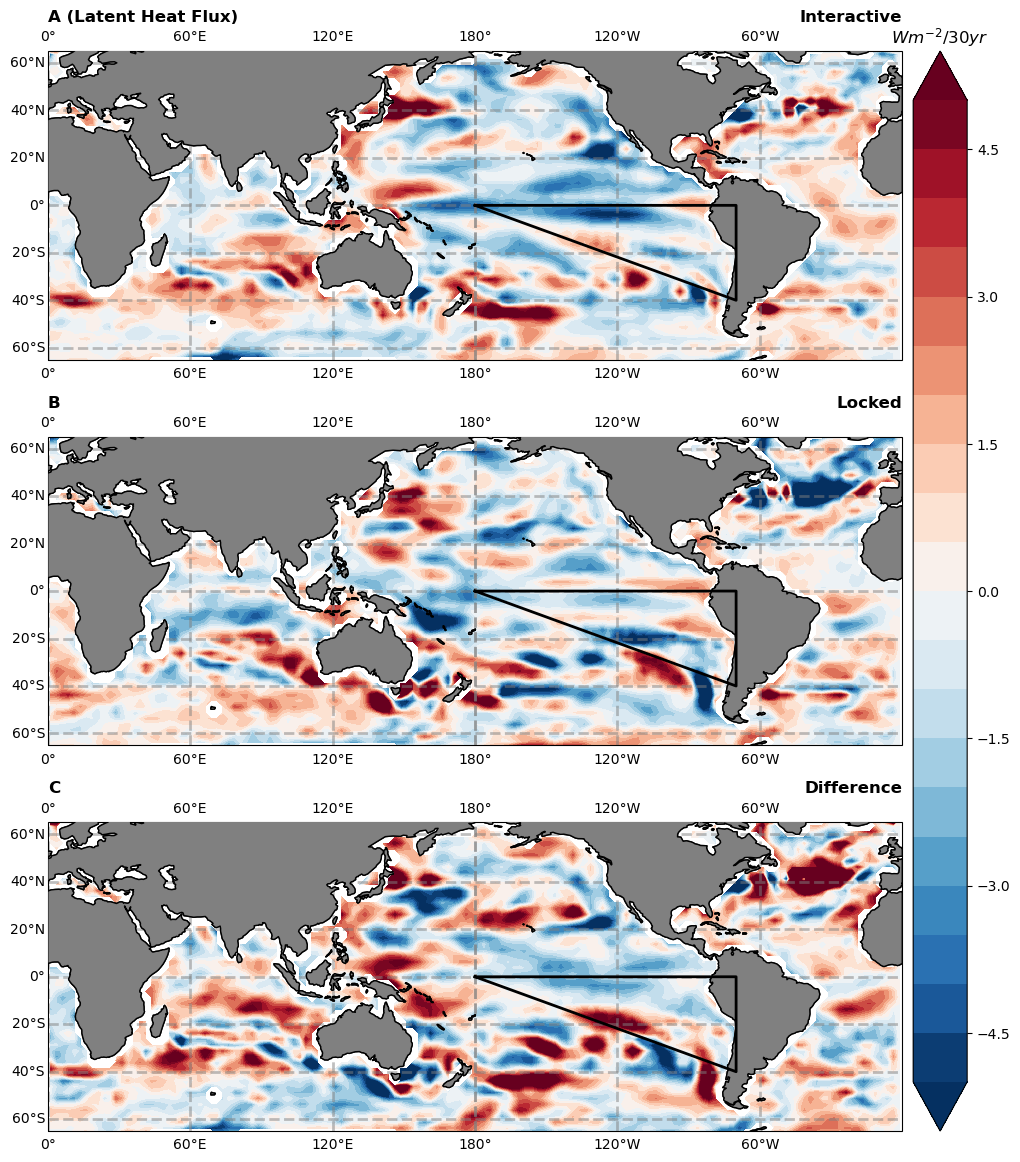

In [219]:
info = {
    "save_name": "ahfl_comp", 
    "right_title_1": "Interactive",
    "right_title_2": "Locked",
    "right_title_3": "Difference",
    "left_title_1": "A (Latent Heat Flux)",
    "left_title_2": "B",
    "left_title_3": "C",
    "cbar_label": r"$Wm^{-2}/30yr$",
    "levels": np.arange(-5, 5.5, .5)
    # "levels": np.arange(-1.0, 1.05, .05)
}

regression_maps(
    ds_int=-regs_int["ahfl_reg_coef"],
    ds_lock=-regs_lock["ahfl_reg_coef"],
    ds_dif=-regs_int["ahfl_reg_coef"] + regs_lock["ahfl_reg_coef"],
    info=info
)

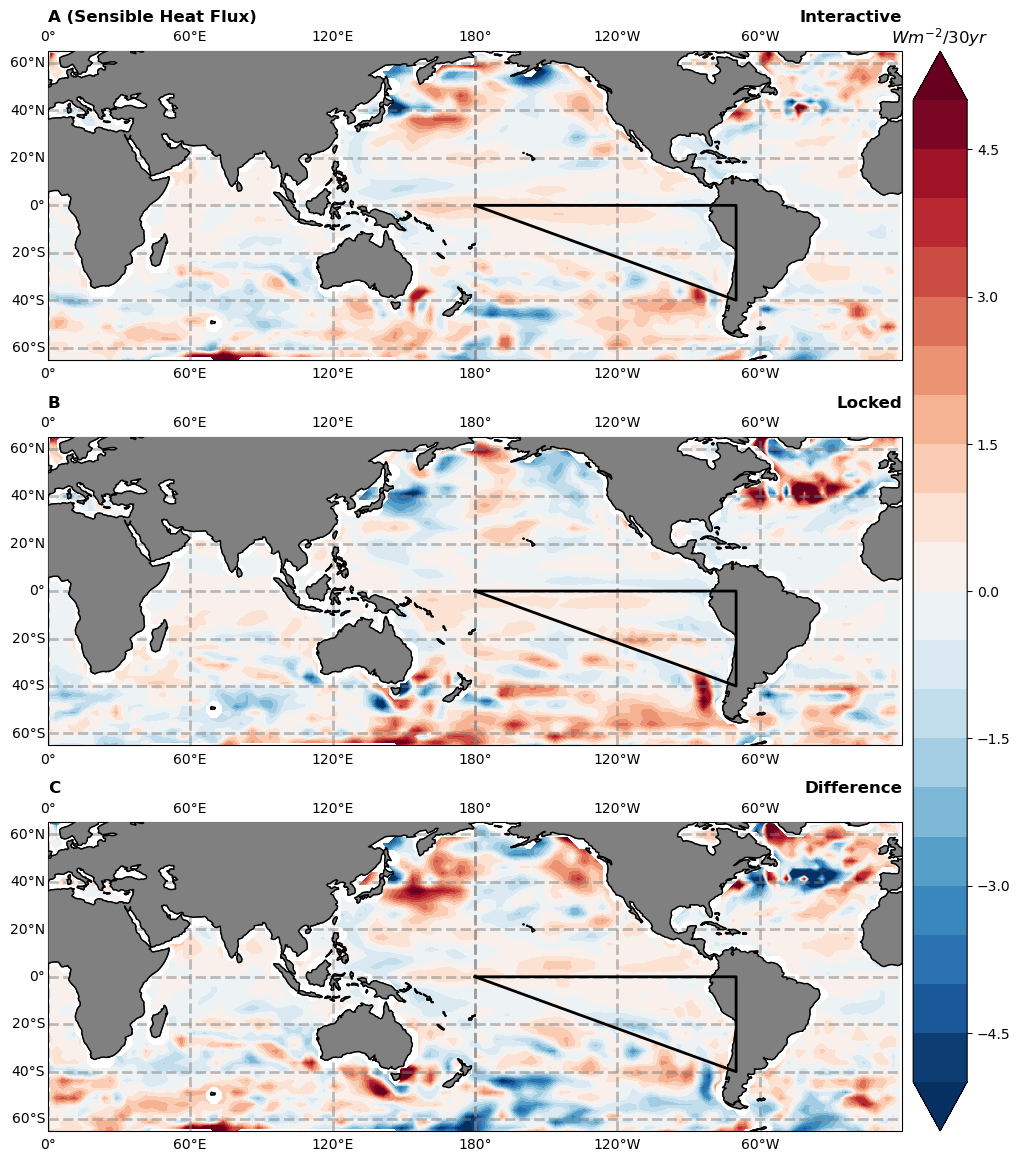

In [216]:
info = {
    "save_name": "ahfs_comp", 
    "right_title_1": "Interactive",
    "right_title_2": "Locked",
    "right_title_3": "Difference",
    "left_title_1": "A (Sensible Heat Flux)",
    "left_title_2": "B",
    "left_title_3": "C",
    "cbar_label": r"$Wm^{-2}/30yr$",
    "levels": np.arange(-5, 5.5, .5)
    # "levels": np.arange(-1.0, 1.05, .05)
}

regression_maps(
    ds_int=regs_int["ahfs_reg_coef"],
    ds_lock=regs_lock["ahfs_reg_coef"],
    ds_dif=regs_int["ahfs_reg_coef"] - regs_lock["ahfs_reg_coef"],
    info=info
)

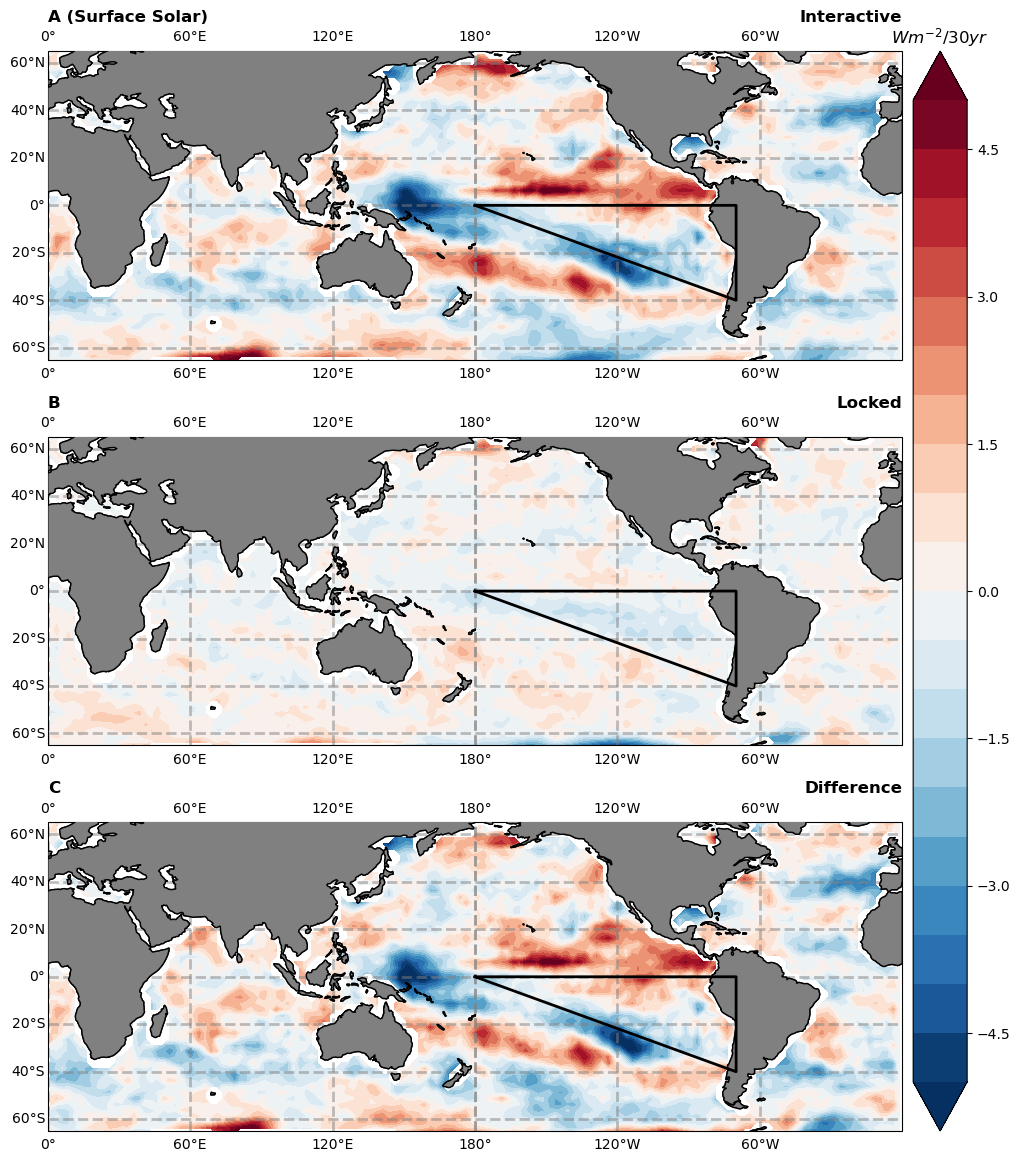

In [221]:
info = {
    "save_name": "srads_comp", 
    "right_title_1": "Interactive",
    "right_title_2": "Locked",
    "right_title_3": "Difference",
    "left_title_1": "A (Surface Solar)",
    "left_title_2": "B",
    "left_title_3": "C",
    "cbar_label": r"$Wm^{-2}/30yr$",
    "levels": np.arange(-5, 5.5, .5)
    # "levels": np.arange(-1.0, 1.05, .05)
}

regression_maps(
    ds_int=-regs_int["srads_reg_coef"],
    ds_lock=-regs_lock["srads_reg_coef"],
    ds_dif=-regs_int["srads_reg_coef"] + regs_lock["srads_reg_coef"],
    info=info
)

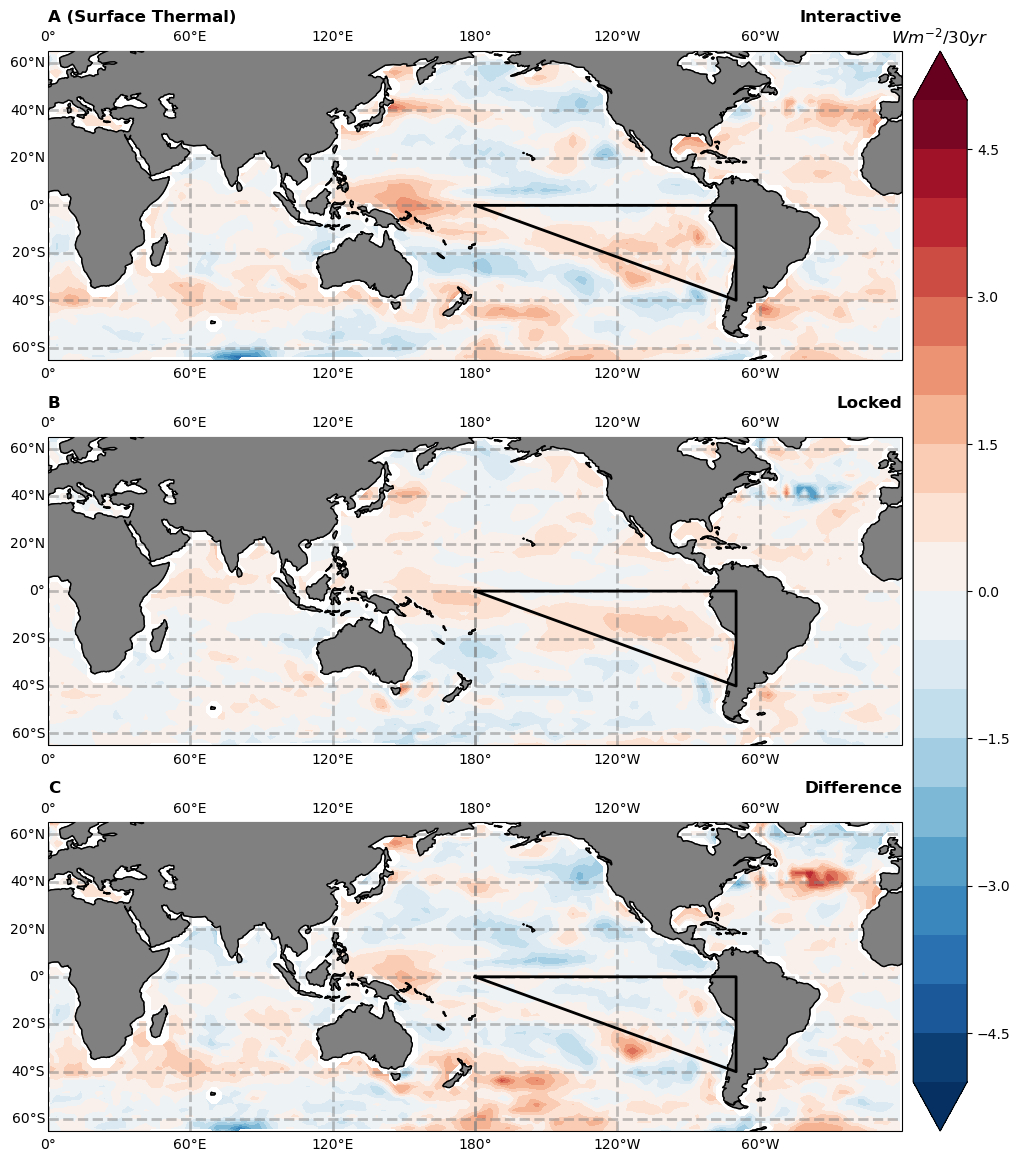

In [220]:
info = {
    "save_name": "trads_comp", 
    "right_title_1": "Interactive",
    "right_title_2": "Locked",
    "right_title_3": "Difference",
    "left_title_1": "A (Surface Thermal)",
    "left_title_2": "B",
    "left_title_3": "C",
    "cbar_label": r"$Wm^{-2}/30yr$",
    # "levels": np.arange(-1.0, 1.05, .05)
    "levels": np.arange(-5, 5.5, .5)
}

regression_maps(
    ds_int=-regs_int["trads_reg_coef"],
    ds_lock=-regs_lock["trads_reg_coef"],
    ds_dif=-regs_int["trads_reg_coef"] + regs_lock["trads_reg_coef"],
    info=info
)

# Look at SWCF for this model

In [8]:
ds_swcf = xr.open_dataset("data/piControl/swcf_cmip5_monthly_1850-2000.nc")

ds_swcf_cesm1cam5 = ds_swcf["swcf"].sel(model="CESM1-CAM5") #.plot()
# ds_swcf_hr = ds_swcf["swcf"].sel(model="MPI-ESM1-2-HR") #.plot()
# ds_swcf_lr = ds_swcf["swcf"].sel(model="MPI-ESM1-2-LR") #.plot()

Text(0.5, 1.0, '$Wm^{-2}K^{-1}$')

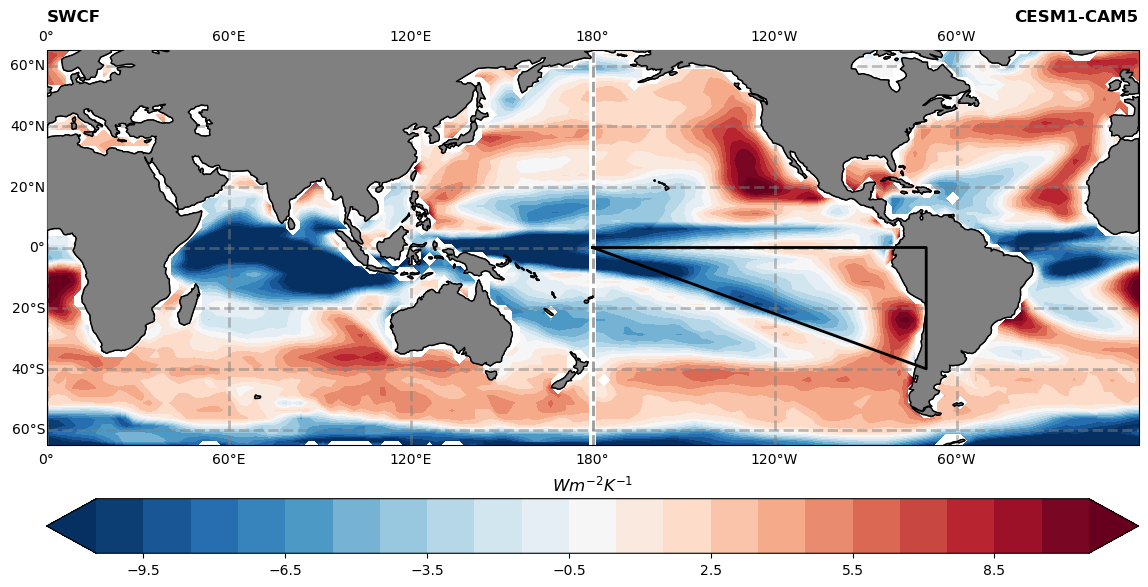

In [18]:
fig = plt.figure(figsize=(12,12))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, hspace=.25, wspace=0.15)

# levels = np.arange(-10, 11, 1)
levels = np.arange(-10.5, 11.5, 1.0)
cmap = "RdBu_r"

img = _global_plot(
    ax1,
    data=ds_swcf_cesm1cam5,
    lat=ds_swcf_cesm1cam5.lat,
    lon=ds_swcf_cesm1cam5.lon,
    levels=levels,
    cmap=cmap, 
    cbar_label="K/30yr"
)

title_fontsize = 12
ax1.set_title("CESM1-CAM5", loc="right", fontweight="bold", fontsize=title_fontsize)
ax1.set_title("SWCF", loc="left", fontweight="bold", fontsize=title_fontsize)
cbar = fig.colorbar(img, ax=[ax1], orientation='horizontal', location="bottom", fraction=.42, pad=0.05)
cbar.ax.set_title(r"$Wm^{-2}K^{-1}$", fontsize=12, fontweight="bold")

Text(0.5, 1.0, '$Wm^{-2}K^{-1}$')

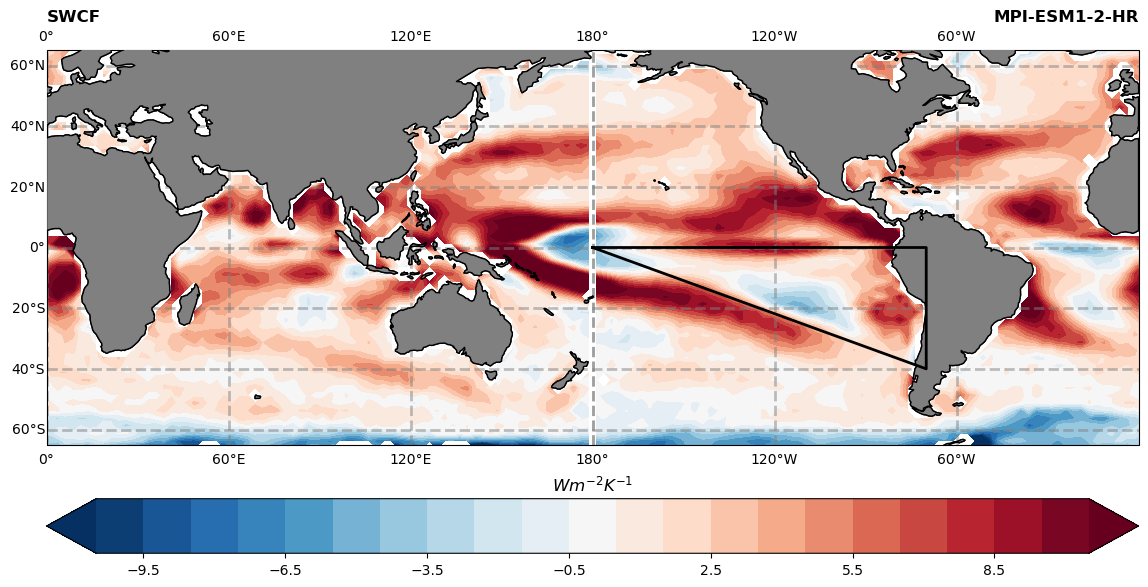

In [18]:
fig = plt.figure(figsize=(12,12))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, hspace=.25, wspace=0.15)

# levels = np.arange(-10, 11, 1)
levels = np.arange(-10.5, 11.5, 1.0)
cmap = "RdBu_r"

img = _global_plot(
    ax1,
    data=ds_swcf_hr,
    lat=ds_swcf_hr.lat,
    lon=ds_swcf_hr.lon,
    levels=levels,
    cmap=cmap, 
    cbar_label="K/30yr"
)

title_fontsize = 12
ax1.set_title("MPI-ESM1-2-HR", loc="right", fontweight="bold", fontsize=title_fontsize)
ax1.set_title("SWCF", loc="left", fontweight="bold", fontsize=title_fontsize)
cbar = fig.colorbar(img, ax=[ax1], orientation='horizontal', location="bottom", fraction=.42, pad=0.05)
cbar.ax.set_title(r"$Wm^{-2}K^{-1}$", fontsize=12, fontweight="bold")

Text(0.5, 1.0, '$Wm^{-2}K^{-1}$')

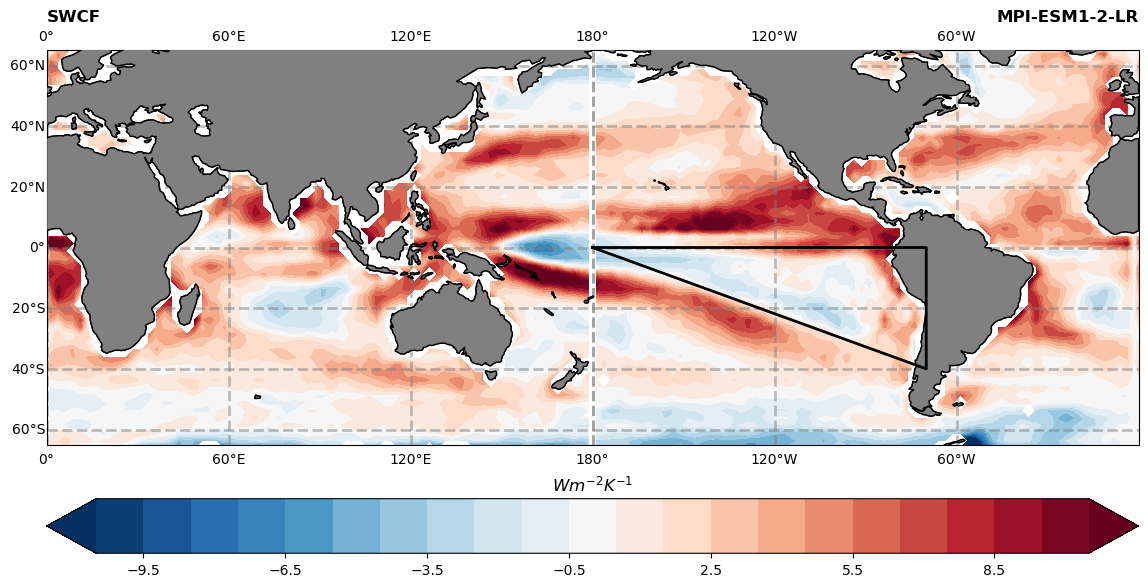

In [19]:
fig = plt.figure(figsize=(12,12))
gs = GridSpec(1, 1)
ax1 = fig.add_subplot(gs[0], projection=ccrs.PlateCarree(central_longitude=180))
fig.subplots_adjust(bottom=0.05, top=0.95, left=0.04, right=0.95, hspace=.25, wspace=0.15)

levels = np.arange(-10.5, 11.5, 1.0)
cmap = "RdBu_r"

img = _global_plot(
    ax1,
    data=ds_swcf_lr,
    lat=ds_swcf_lr.lat,
    lon=ds_swcf_lr.lon,
    levels=levels,
    cmap=cmap, 
    cbar_label="K/30yr"
)

title_fontsize = 12
ax1.set_title("MPI-ESM1-2-LR", loc="right", fontweight="bold", fontsize=title_fontsize)
ax1.set_title("SWCF", loc="left", fontweight="bold", fontsize=title_fontsize)
cbar = fig.colorbar(img, ax=[ax1], orientation='horizontal', location="bottom", fraction=.42, pad=0.05)
cbar.ax.set_title(r"$Wm^{-2}K^{-1}$", fontsize=12, fontweight="bold")